In [1]:
import json
import os
import sys

import numpy as np
from skimage.io import imread

sys.path.append('..')

from utils.data_processing import set_generator_object_detector
from utils.visualisers import plot_images
from src.vyn_augment.augmentor import Augmentor

In this example, we will make use of the generator in the utils directory. This generator takes as input a list of tuples, where the first value is a label and the rest are whatever the user needs to create a batch of images and process the data. Then, it randomly selects a tuple from the list and pass it to a function that the user must provide. This function named `preprocessing_function`, will take the tuple and will return a processed image and the ground truth of the model output. In this example, since we are dealing with classification, the output would be the label of the image

Lastly, the generator will joined a set of processed images and the other data and return a batch at each iteration.

In [2]:
def pre_processing_function(bb_filename: str, filename: str, augmentor: Augmentor = None):
    """
    Pre-processing function. This function is run within the generator and it is performed to each individual image
    regardless the batch size.
    :param mask_filename: The filename where the mask is stored.
    :param filename: The complete path to the image file
    :param augmentor: An object of type Augmentor
    :return:
    """
    with open(bb_filename, 'r') as f:
        bbs = json.load(f)
    image = imread(filename)

    # Augmentor expects the bounding boxes to be 4 values only instead of 5 with the label, so we are going to
    # remove it and then add it again. In addition, the values must be integers.
    h, w = image.shape[:2]
    sizes = [w, h, w, h]
    classes = []
    bbs2 = []
    for bb_i in bbs:
        classes.append(bb_i[0])
        bbs2.append([int(round(size * coord)) for coord, size in zip(bb_i[1:], sizes)])

    if augmentor is not None:
        output = augmentor.run(image, use_colour=-1, bounding_boxes=[bbs2])
        bbs2 = output['bounding_boxes'][0]
        image = np.round(output['images']).astype(np.uint8)

    # We need to add the labels again
    bbs = []
    for bb_i, class_i in zip(bbs2, classes):
        bbs.append([class_i] + [coord/float(size) for coord, size in zip(bb_i, sizes)])

    return image, [bbs]

`vyn_augment` employs a dictionary with the transformation as keys and the inputs as values or another dictionary with keys `values` and the extra keys. The main reason to use this second approach is to change the probability of the transformation to be used.

In the case of object detection, one can use any transformation, but to keep the bounding boxes aligned it is necessary to pass the bounding boxes when running the augmentor. This was done in the `pre-processing-function`. 
```
output = augmentor.run(images, use_colour=-1, bounding_boxes=bbs)
```
Where bbs with the same length as images and each element is a list with all the bounding boxes of that particular image. Lastly, each bounding box contains 4 number [x_left, y_top, x_right, y_bottom]

In addition, the operations can be applied only to the region of the image inside the bounding box. To do this the operation must include the name with \_object.

As usual if the same augmentation must be performed more than once, for instance we want to rotate an image between -15 and 15 degrees or between 30 and 45 degrees, the key with the name `rotate` can have any number after it.
```
{
...
'rotate': (-15, 15),
'rotate1': (30, 45),
...
}
```
Another example is the brightness operation in the function `set_augmentor()` below. If the operations should not be used in the same augmentation (It should select between rotate and rotate1 and not both of them), use the `no_repetition` flag when creating the Augmentor object. 

For the meaning of the values, check the `README.md`.

In [3]:
def set_augmentor():
    """
    Set the augmentor.
    1. Select the operations and create the config dictionary
    2. Pass it to the Augmentor class with any other information that requires
    3. Return the instance of the class.
    :return:
    """
    # Operations that must be only applied inside the bounding boxes have a _object after the operation
    config = {'blur': {'values': ('gaussian', 0.7, 1.0), 'prob': 0.3},
              'brightness': {'values': (0.6, 1.0), 'prob': 0.1},
              'brightness1': {'values': (1.0, 1.5), 'prob': 0.1},
              'flip': {'values': ('hor',), 'prob': 0.5},
              'flip_object': {'values': ('hor',), 'prob': 0.5},
              'grid_mask_object': {'values': (0, 0.2, 0, 0.2, 0.1, 0.15, 0.1, 0.15, 0.2, 0.3, 0.2, 0.3),
                                   'prob': 0.3},
              'occlusion': {'values': ('hide_and_seek', 0.2, 0.4, 0.2, 0.3), 'prob': 0.4},
              'posterisation': {'values': (32, 64), 'prob': 0.5},
              'rotate': {'values': (-45, 45), 'prob': 0.4},
              'translate': {'values': ('RANDOM', -0.2, 0.2), 'prob': 0.2, 'use_replication': False},
              'translate_object': {'values': ('RANDOM', -0.1, 0.1), 'prob': 0.25, 'use_replication': True},
              'zoom': {'values': (0.5, 1.5), 'prob': 0.9, 'use_replication': False},
              'zoom_object': {'values': (0.5, 1.5), 'prob': 0.9, 'use_replication': False}}

    augmentor = Augmentor(config, no_repetition=True)

    return augmentor

The use case performs the following operations:
1. Get the augmentor using set_augmentor()
2. Get the generator with set_generator()
3. Get the augmented images and plot them with the augmented bounding boxes

The process may take a while and should print as many images as the hyper parameter n below with their transformed bounding_boxes. The function `plot_images` will create a figure with 4 columns and `ceil(n/4)` rows.

In [4]:
data_dirname = '../images/object_detection'
n=20  # Number of images

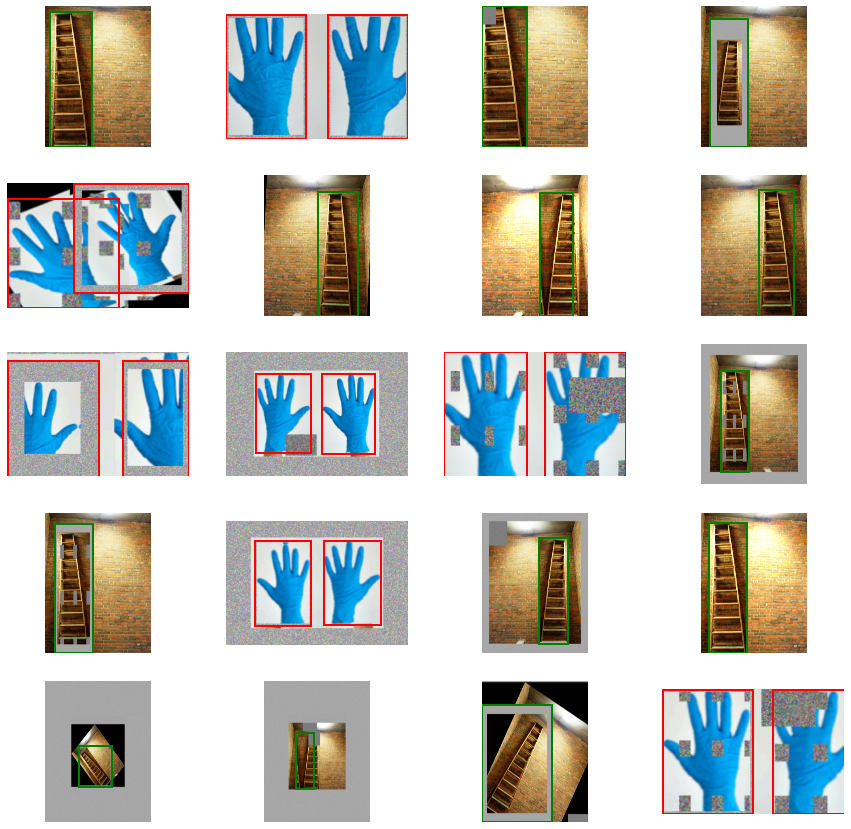

In [9]:
input_image_dirname = os.path.join(data_dirname, 'images')
input_bb_dirname = os.path.join(data_dirname, 'bounding_boxes')

augmentor = set_augmentor()
preprocessing_fun = lambda *args: pre_processing_function(*args, augmentor=augmentor)
generator = set_generator_object_detector(input_image_dirname, input_bb_dirname, preprocessing_fun,
                                    batch_size=1, number_of_images=n)
generator.not_batch = True
# NOTICE: This generator can be used for keras and pytorch in case that instead of saving images one desires to
# augment images on the fly. Use a number larger than 1 for the batch size when training directly a CNN.


# For an example saving the the new generated images, check bin folder.
all_bbs = []
images = []
for image, bbs in generator:
    images.append(image)
    all_bbs.append(bbs)

plot_images(images, bbs=all_bbs, figsize=(15, 3*(n//4)))
